# Dummy Model

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Dummy model
class DummyModel(nn.Module):
    def __init__(self):
        super(DummyModel, self).__init__()
        self.fc1 = nn.Linear(10, 20)
        self.fc2 = nn.Linear(20, 5)

    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

# Dummy dataset
inputs = torch.rand(100, 10)  # 100 samples, 10 features each
targets = torch.randint(0, 5, (100,))  # 100 labels in 5 classes
dataset = TensorDataset(inputs, targets)
train_loader = DataLoader(dataset, batch_size=10)
test_loader = DataLoader(dataset, batch_size=10)


# Dummy Model Training

In [ ]:
# Model, loss function, optimizer
model = DummyModel()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
epochs = 5
for epoch in range(epochs):
    model.train()  # Training mode
    for inputs, targets in train_loader:
        inputs, targets = inputs, targets  # Move to device if necessary

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


# SAFT

In [76]:
def select_important_parameters(model, dataloader, criterion, sparsity_level):
    """
    Accumulate gradients and select important parameters based on gradient magnitudes.

    Args:
        model (torch.nn.Module): The pre-trained model.
        dataloader (DataLoader): DataLoader for the downstream task.
        criterion (callable): Loss function (e.g., CrossEntropyLoss).
        sparsity_level (float): Fraction of parameters to select for fine-tuning.

    Returns:
        dict: Dictionary of selected parameters (names and values).
        int: Total number of parameters.
        int: Total number of selected parameters.
    """
    model.eval()  # Ensure model is in evaluation mode
    model.zero_grad()
    param_gradients = {name: torch.zeros_like(param) for name, param in model.named_parameters()}
    total_samples = 0
    

    # Iterate over batches without zeroing gradients
    for inputs, targets in dataloader:
        
        # You can uncomment following line if you have same device error
        #inputs, targets = inputs.to(next(model.parameters()).device), targets.to(next(model.parameters()).device)

        # Forward pass
        outputs = model(inputs)

        # You can uncomment following to handle case where model returns a tuple
        #if isinstance(outputs, tuple):
        #    outputs = outputs[0]

        # Compute loss
        loss = criterion(outputs, targets)

        # Backward pass to compute gradients
        loss.backward()

        # Accumulate gradients for all parameters
        for name, param in model.named_parameters():
            if param.grad is not None:  # Only accumulate if parameter has gradients
                param_gradients[name] += param.grad.abs()

        total_samples += len(targets)

    # Average gradients across all samples
    for name in param_gradients:
        param_gradients[name] /= total_samples

    # Flatten and sort all gradients to determine the threshold
    all_gradients = torch.cat([g.view(-1) for g in param_gradients.values()])

    # Sort all gradients in descending order
    sorted_gradients, _ = torch.sort(all_gradients, descending=True)

    # Determine the number of parameters to select
    num_selected = int(len(sorted_gradients) * sparsity_level)
    if num_selected < 1: # to prevent zero error
        num_selected = 1 
    threshold = sorted_gradients[num_selected - 1]  # Threshold value for top gradients

    # Select important parameters based on the threshold
    selected_parameters = {}
    total_selected = 0  # Count total selected parameters
    for name, grad in param_gradients.items():
        if torch.any(grad >= threshold):
            mask = grad >= threshold  # Create a mask for selected values
            selected_parameters[name] = mask
            total_selected += mask.sum().item()

    total_parameters = sum(g.numel() for g in param_gradients.values())
    return selected_parameters, total_parameters, total_selected, threshold, param_gradients


Selected Threshold: 0.0065 

Selected Parameters:
Parameter: fc1.weight, Selected Count: 11, Total Count: 200
Parameter: fc1.bias, Selected Count: 3, Total Count: 20
Parameter: fc2.weight, Selected Count: 13, Total Count: 100
Parameter: fc2.bias, Selected Count: 5, Total Count: 5

Total Parameters: 325
Total Selected: 32
Selection Ratio: 9.85%


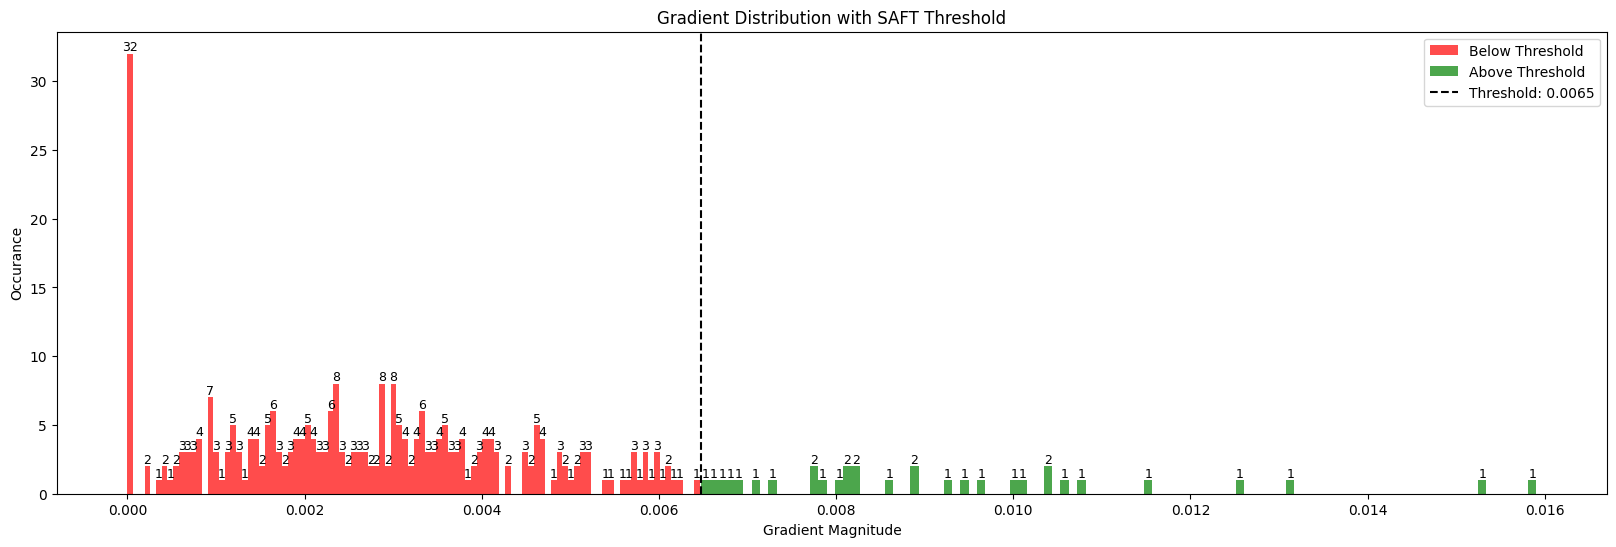

In [77]:
import matplotlib.pyplot as plt
import numpy as np


# SAFT Selection
alpha = 0.1 # Select top 10% of parameters
selected_params, total_params, total_selected, threshold, param_gradients = select_important_parameters(model, test_loader, criterion, alpha)

# Print results
print(f"Selected Threshold: {threshold:.4f} ")
print("\nSelected Parameters:")
for name, mask in selected_params.items():
    print(f"Parameter: {name}, Selected Count: {mask.sum().item()}, Total Count: {mask.numel()}")

print(f"\nTotal Parameters: {total_params}")
print(f"Total Selected: {total_selected}")
print(f"Selection Ratio: {total_selected / total_params:.2%}")

#visualization 
all_gradients = torch.cat([g.view(-1) for g in param_gradients.values()])
below_threshold = all_gradients[all_gradients < threshold].cpu().numpy()
above_threshold = all_gradients[all_gradients >= threshold].cpu().numpy()
bins = 100
counts_below, bin_edges_below = np.histogram(below_threshold, bins=bins)
counts_above, bin_edges_above = np.histogram(above_threshold, bins=bins)

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))
plt.hist(below_threshold, bins=bins, alpha=0.7, label='Below Threshold', color='red')
plt.hist(above_threshold, bins=bins, alpha=0.7, label='Above Threshold', color='green')
for i in range(len(counts_below)): # print number of occurances on top of the bar
    if counts_below[i] > 0:  # Only non-zero bars
        plt.text((bin_edges_below[i] + bin_edges_below[i + 1]) / 2, counts_below[i], str(counts_below[i]),
                 ha='center', va='bottom', fontsize=9, color='black')
for i in range(len(counts_above)): # print number of occurances on top of the bar
    if counts_above[i] > 0:  # Only non-zero bars
        plt.text((bin_edges_above[i] + bin_edges_above[i + 1]) / 2, counts_above[i], str(counts_above[i]),
                 ha='center', va='bottom', fontsize=9, color='black')

plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.4f}')
plt.legend()
plt.title("Gradient Distribution with SAFT Threshold")
plt.xlabel("Gradient Magnitude")
plt.ylabel("Occurance")
plt.show()
